### Poisson

**In reality, poisson distribution performs more like zero-inflated poisson distribution**        
**Many smaller valued samples**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import scipy.stats as stats
import pymc3 as pm
import arviz as az
sns.set()

#### 1. The poisson PMF

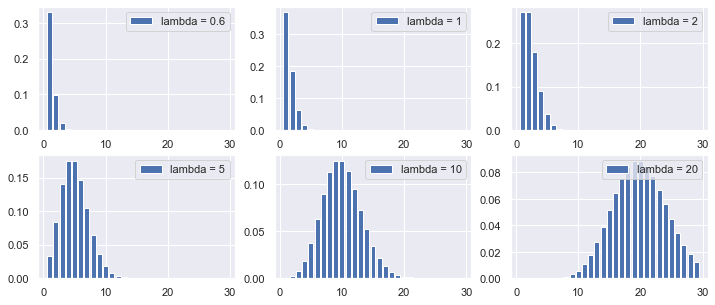

In [2]:
figsize(12,5)
for i, lam in enumerate([0.6,1,2,5,10,20]):
    plt.subplot(2,3,i+1)
    vals = np.arange(1,30)
    probs = [stats.poisson(lam).pmf(i) for i in vals]
    plt.bar(vals, probs, label = 'lambda = {}'.format(lam))
    plt.legend(loc = 'upper right')
plt.show()

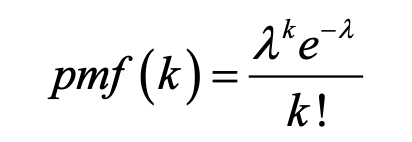

当k = 0的时候，$pmf(0) = e^{-\lambda}$    
真实的柏松分布中，我们经常遇到0非常多的情况   
$y = 1 - \phi + \phi * e^{-\lambda}$

#### How the data is generated

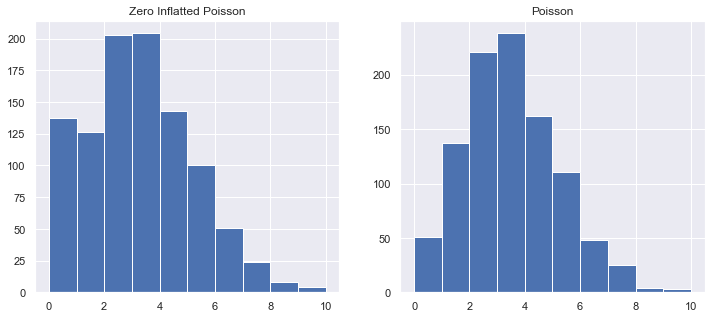

In [29]:
N = 1000
phi = 0.1
lam = 3

plt.subplot(1,2,1)
data = (np.random.random(N) > phi).astype(int) * stats.poisson(lam).rvs(N)
plt.hist(data)
plt.title('Zero Inflatted Poisson')

plt.subplot(1,2,2)
plt.hist(stats.poisson(lam).rvs(N))
plt.title('Poisson')
plt.show()

#### Zero inflated model with pymc(may be wrong)

In [30]:
idx = np.arange(len(data))
with pm.Model() as model:
    phi = pm.Beta('phi',1,1)
    p = pm.Beta('p',1,1, shape = N)
    lam = pm.Exponential('lam', 1/4)
    lamb_zero = pm.math.switch(p > phi, 0, lam)
    obs = pm.Poisson('obs', lamb_zero, observed = data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(30000, return_inferencedata = True, start = start, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lam]
>Metropolis: [p]
>Metropolis: [phi]


Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


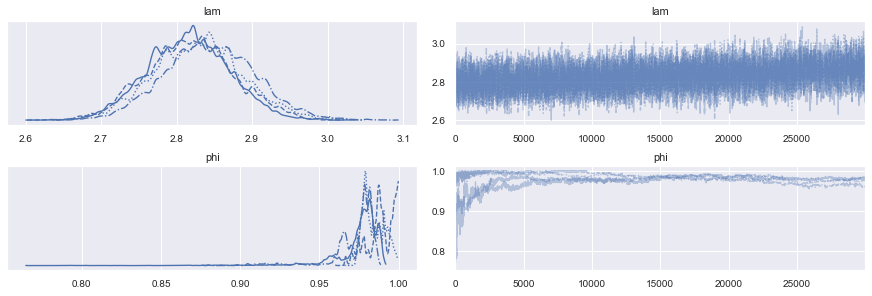

In [31]:
az.plot_trace(trace, var_names = ['lam','phi'])
plt.show()

In [32]:
az.summary(trace, var_names = ['lam','phi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,2.827,0.059,2.717,2.938,0.012,0.008,27.0,108.0,1.09
phi,0.980,0.015,0.962,1.000,0.005,0.004,6.0,16.0,1.70


#### Posterior Predictive Checks

In [38]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["lam", "phi", "obs"], random_seed=42
    )

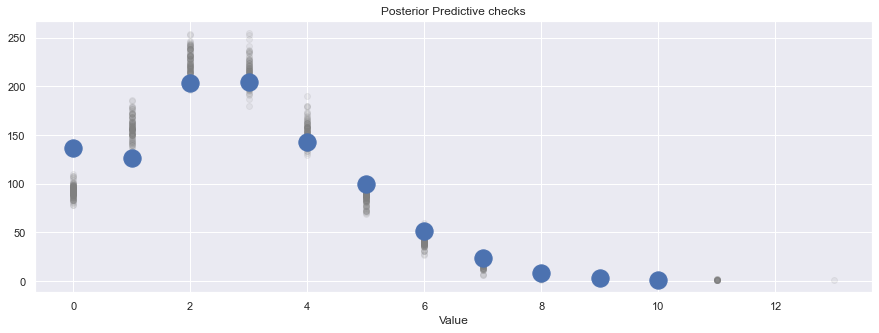

In [63]:
figsize(15,5)
for s in ppc['obs'][-100:]:
    val, cnt = np.unique(s, return_counts = True)
    plt.scatter(val, cnt, color = 'gray', alpha = .1)
val, cnt = np.unique(data, return_counts = True)
plt.scatter(val, cnt, s = 300)
plt.title('Posterior Predictive checks')
plt.xlabel('Value')
plt.show()

### Zero Inflated Poisson comes with PYMC